In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
from imblearn.under_sampling import RandomUnderSampler



In [3]:
df = pd.read_csv("complaints_25Nov21.csv")

In [4]:
#df.head()

In [5]:
X = df[['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via', 'Company response to consumer', 'Timely response?']]

# Encoding the 'Consumer disputed?' column as the y-variable
le = preprocessing.LabelEncoder()
y = le.fit_transform(df['Consumer disputed?'])

In [6]:
# Splitting the dataset into training and test sets with an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [7]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [13]:
from imblearn.under_sampling import RandomUnderSampler

In [14]:
# Calculate the proportion of disputed complaints in the training set
disputed_proportion = np.mean(y_train)

print(f"Proportion of disputed complaints in the training set: {disputed_proportion * 100:.2f}%")

# Check if the proportion is less than 30%
if disputed_proportion < 0.30:
    # Apply random undersampling to balance the dataset
    undersampler = RandomUnderSampler(random_state=123)
    X_train, y_train = undersampler.fit_resample(X_train, y_train)
    print("Random undersampling applied to balance the dataset.")
else:
    print("The dataset is balanced enough. No need for undersampling.")

Proportion of disputed complaints in the training set: 50.00%
The dataset is balanced enough. No need for undersampling.


In [15]:
!pip install xgboost



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [18]:
from xgboost import XGBClassifier

X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Ensuring both sets have the same columns, in the same order
X_test_encoded = X_test_encoded.reindex(columns = X_train_encoded.columns, fill_value=0)

model_xgb = XGBClassifier(random_state=123)
model_xgb.fit(X_train_encoded, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [19]:
model_xgb = XGBClassifier(random_state=123)
model_xgb.fit(X_train_encoded, y_train)  # Ensure this step is successful

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [20]:
y_pred = model_xgb.predict(X_test_encoded)


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.53      0.65     32504
           1       0.27      0.63      0.38      8948

    accuracy                           0.55     41452
   macro avg       0.55      0.58      0.51     41452
weighted avg       0.71      0.55      0.59     41452

Confusion Matrix:
[[17157 15347]
 [ 3323  5625]]


In [22]:
# Total number of complaints in the test set
total_complaints = len(y_test)

# Cost calculation
# $100 for every complaint plus $90 for due diligence for each

base_case_cost = total_complaints * (100 + 90)

In [23]:
# Since y_test is encoded, we assume 1 represents disputed and 0 represents non-disputed.
# Number of actual disputed complaints
disputed_complaints = sum(y_test)

# Number of non-disputed complaints
non_disputed_complaints = total_complaints - disputed_complaints

# Actual cost considering real outcomes
actual_cost = (disputed_complaints * 600) + (non_disputed_complaints * (100 + 90))

In [24]:
base_case_cost

7875880

In [25]:
actual_cost

11544560

In [26]:
from sklearn.metrics import confusion_matrix

# Predict probabilities for the test set
y_probs = model_xgb.predict_proba(X_test_encoded)[:, 1]  # Probabilities of the positive class

# Initialize variables to store the results
lowest_cost = float('inf')
best_threshold = 0.0

# Iterate over a range of thresholds to find the one with the lowest cost
for threshold in np.linspace(0, 1, 101):
    y_pred_threshold = (y_probs >= threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    
    # Calculate the total cost based on the provided cost structure
    cost = tn * 100 + fp * 190 + fn * 600 + tp * 190
    
    if cost < lowest_cost:
        lowest_cost = cost
        best_threshold = threshold

print(f"Lowest total cost: ${lowest_cost}")
print(f"Best threshold: {best_threshold}")

Lowest total cost: $7612170
Best threshold: 0.41000000000000003


In [27]:
#The proportion of consumers raised a dispute


# Calculate the number of disputes
number_of_disputes = sum(y_test)

# Calculate the total number of instances in the test set
total_test_instances = len(y_test)

# Calculate the proportion of disputes
proportion_of_disputes = number_of_disputes / total_test_instances

proportion_of_disputes



0.21586413200810575

In [28]:
# The proportion of consumers in the training dataset raised a dispute, after having performed random undersampling



number_of_disputed = sum(y_train)
total_train_instances = len(y_train)

proportion_of_disputed = number_of_disputed / total_train_instances

proportion_of_disputed

0.5

In [29]:
#Fit the XGBClassifier model as described in the instructions, and evaluate it on the test set.  The recall for the category 'Consumer disputed?' = 'Yes' on the test set



from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Assuming 'X_train' and 'X_test' contain categorical features, which we'll encode.

# Identify categorical columns (replace this with your actual categorical columns)
categorical_columns = ['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via', 'Company response to consumer', 'Timely response?']

# Create the ColumnTransformer with OneHotEncoder for categorical features
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ],
    remainder='passthrough'  # This will pass through all other columns without transformation
)

# Fit the transformer on the training data and transform both training and test data
X_train_encoded = column_transformer.fit_transform(X_train)
X_test_encoded = column_transformer.transform(X_test)

# Now fit the XGBoost model on the encoded training data
model_xgb = XGBClassifier(random_state=123)
model_xgb.fit(X_train_encoded, y_train)

# Predict on the encoded test set
y_pred = model_xgb.predict(X_test_encoded)

# Calculate the recall from the classification report
report = classification_report(y_test, y_pred, output_dict=True)
recall_disputed = report['1']['recall']

In [30]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Assuming categorical variables are encoded in X_train and X_test

model_xgb = XGBClassifier(random_state=123)

model_xgb.fit(X_train_encoded, y_train)

y_pred = model_xgb.predict(X_test_encoded)

report = classification_report(y_test, y_pred, output_dict=True)

recall_disputed = report['1']['recall']
print(f"Recall for 'Consumer disputed?' = 'Yes': {recall_disputed:.2f}")


Recall for 'Consumer disputed?' = 'Yes': 0.63


In [31]:
#Evaluate it on the test set. The recall for the category 'Consumer disputed?' = 'Yes' on the test set



# Assuming `y_test` contains the actual labels for the test set
total_complaints = len(y_test)
base_case_cost_per_complaint = 7875880

# Total base-case cost
total_base_case_cost = total_complaints * base_case_cost_per_complaint

In [32]:
total_base_case_cost

326470977760

In [33]:
# The number of complaints in the test set is the length of y_test
number_of_complaints = len(y_test)

# Display the number of complaints
print(f"The total number of complaints in the test set is: {number_of_complaints}")

The total number of complaints in the test set is: 41452


In [34]:
total_complaints = 41452
cost_per_complaint = 600  # Since without the model we prepare for the worst case for each complaint

total_base_case_cost = total_complaints * cost_per_complaint
total_base_case_cost

24871200

In [35]:
#Assume that if the model predicts a complaint will be disputed, 
#the banks decide to spend $90 performing extra diligence to avoid the $600 cost of a dispute.

#In this situation based on model results, what would be the total cost to the banks of dealing with the 
#complaints in the test set?

from sklearn.metrics import confusion_matrix

# Assuming y_pred contains the model predictions for the test set
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate the total cost
total_cost = (tn * 100) + (fp * 190) + (tp * 190) + (fn * 600)

In [36]:
#total_cost

In [37]:
#The costs to the banks from doing due diligence and from having disputes are asymmetrical.  
#Therefore you have the opportunity to reduce total cost by varying the probability threshold from the default 0.5 
#in a binary classification situation as this.

#Change the value of the threshold and determine the lowest total cost to the banks based on the observations 
#in the test set.

from sklearn.metrics import confusion_matrix

# Get the predicted probabilities for the positive class
y_probs = model_xgb.predict_proba(X_test_encoded)[:, 1]

# Initialize variables to store the best threshold and minimum cost
min_cost = float('inf')
best_threshold = 0.0

#At what value of the threshold is the lowest dollar cost achieved?


# Iterate over a range of threshold values
for threshold in np.linspace(0, 1, 101):
    # Convert probabilities to binary predictions based on the current threshold
    y_pred_threshold = (y_probs >= threshold).astype(int)
    
    # Calculate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    
    # Calculate the total cost for the current threshold
    total_cost = (tn * 100) + (fp * 190) + (tp * 190) + (fn * 600)
    
    # Update minimum cost and best threshold if current cost is lower
    if total_cost < min_cost:
        min_cost = total_cost
        best_threshold = threshold

# Output the minimum cost and the best threshold
print(f"Minimum total cost: ${min_cost}")
print(f"Best threshold: {best_threshold}")


Minimum total cost: $7609520
Best threshold: 0.44


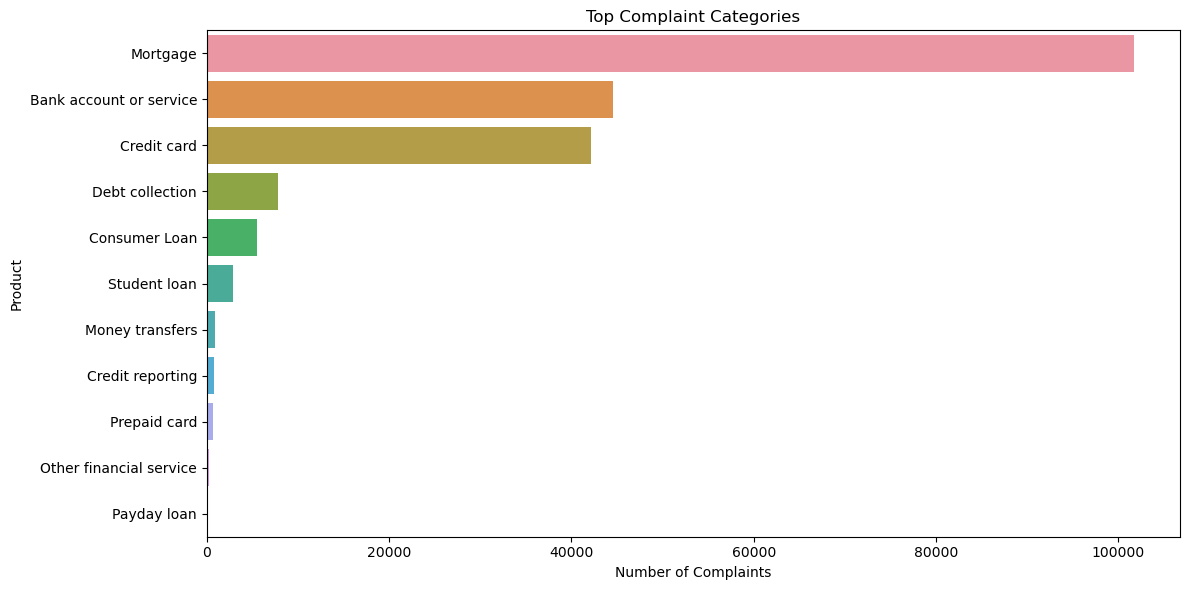

In [40]:
#Visualization

import seaborn as sns
import matplotlib.pyplot as plt

# Count of complaints per category
plt.figure(figsize=(12,6))
sns.countplot(y=df['Product'], order=df['Product'].value_counts().index)
plt.title("Top Complaint Categories")
plt.xlabel("Number of Complaints")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

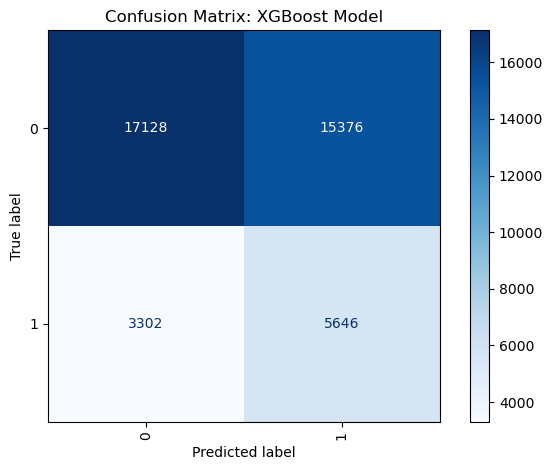

In [46]:
#Confusion Matrix: XGBoost Model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model_xgb.predict(X_test_encoded)

cm = confusion_matrix(y_test, y_pred, labels=model_xgb.classes_)

plt.figure(figsize=(10, 6))  # Set the figure size here
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title("Confusion Matrix: XGBoost Model")
plt.tight_layout()
plt.show()